# Trabalho 1
Matéria: Processamento de Linguagem Natural <br>
Dupla/Matrícula: Bianca Nunes Coelho - 15102880, Raíssa Nunes Coelho - 15102887 <br> 

## Introdução

Multi Class Classification <br>

## Bibliotecas
Bibliotecas do ptyhon utilizadas neste trabalho estão a seguir.

In [1]:
import pandas as pd
import re
import nltk
import spacy
import gensim
import matplotlib.pyplot as plt

## Datasets
Datasets utilizados estão definidos a seguir.

In [2]:
file = "train-00000-of-00001-ecf072e7202447d8.parquet"
df = pd.read_parquet(file, engine= 'pyarrow')

In [3]:
len(df)

3877

In [4]:
df.head(4)

,titulo,texto,link,resumo,categoria,data_hora
0,"Veja a trajetória de Fernando Diniz, em busca ...",Se tem um treinador que sempre foi badalado pe...,https://www.cnnbrasil.com.br/esportes/veja-a-t...,Técnico tricolor e da Seleção Brasileira tem a...,esportes,2023-11-04 12:26:18
1,"Após tempestade com ventos, São Paulo terá sáb...",Após uma tempestade com ventos de mais de 100 ...,https://www.cnnbrasil.com.br/nacional/apos-tem...,"Termômetros devem chegar a 26ºC, esquentando a...",nacional,2023-11-04 12:15:44
2,Como os aplicativos de relacionamento “arruina...,Jenny Nguyen-Don estava com vontade de comer f...,https://www.cnnbrasil.com.br/tecnologia/como-o...,Pessoas em busca de relacionamentos afirmam qu...,tecnologia,2023-11-04 12:15:07
3,Fluminense pode ser o 26º clube a levantar a t...,O Fluminense vai em busca do primeiro título d...,https://www.cnnbrasil.com.br/esportes/fluminen...,"Em busca do título inédito, o Tricolor carioca...",esportes,2023-11-04 12:05:24


## Balanceamento

In [5]:
df['categoria'].value_counts()

esportes           960
nacional           623
internacional      618
economia           562
politica           507
entretenimento     450
tecnologia          44
saude               41
noticias            38
lifestyle           21
branded-content     13
Name: categoria, dtype: int64

<AxesSubplot: >

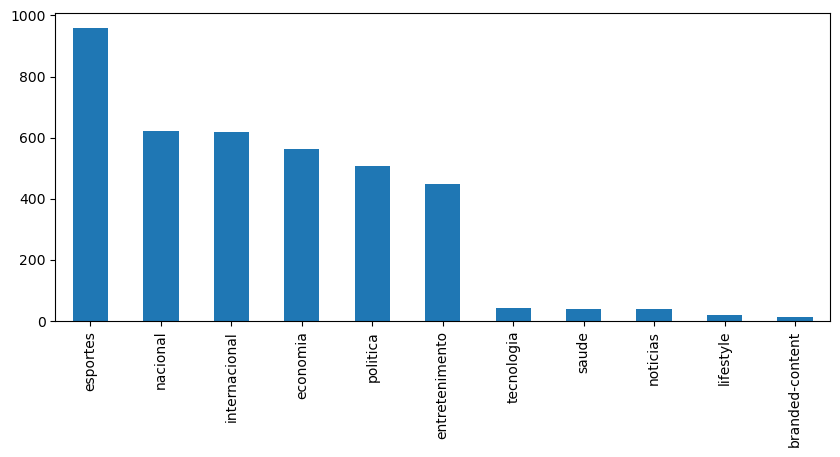

In [6]:
plt.figure(figsize=(10,4))
df.categoria.value_counts().plot(kind='bar')

In [7]:
indice_linha_remover = ['tecnologia',  'saude','noticias','lifestyle','branded-content']

In [8]:
df = df[~df['categoria'].isin(indice_linha_remover)]

In [9]:
df['categoria'].value_counts()

esportes          960
nacional          623
internacional     618
economia          562
politica          507
entretenimento    450
Name: categoria, dtype: int64

In [10]:
# Undersampling
min = df['categoria'].value_counts().min()

amostras = []

for i in df['categoria'].value_counts().index:
    a = df[df['categoria'] == i].sample(min, replace=False)
    amostras.append(a)

df_balanceado = pd.concat(amostras)

In [11]:
df_balanceado['categoria'].value_counts()

esportes          450
nacional          450
internacional     450
economia          450
politica          450
entretenimento    450
Name: categoria, dtype: int64

In [12]:
df_balanceado = df_balanceado.reset_index(drop=True)
df_balanceado.head(5)

,titulo,texto,link,resumo,categoria,data_hora
0,"Acusado de matar a esposa, ex-lutador pode peg...",O ex-lutador de MMA Luís Paulo dos Santos vai ...,https://www.cnnbrasil.com.br/esportes/acusado-...,"Ex-lutador de MMA, Luís Paulo dos Santos, vai ...",esportes,2023-11-21 12:54:52
1,Brasileirão: veja as escalações de Flamengo e ...,Flamengo e Palmeiras estão escalados para o du...,https://www.cnnbrasil.com.br/esportes/brasilei...,"De olho no título, times duelam pela 33ª rodad...",esportes,2023-11-08 23:46:36
2,Romênia x Suíça: tempo real e onde assistir ao...,"Nesta terça-feira (21), Romênia e Suíça se enf...",https://www.cnnbrasil.com.br/esportes/romenia-...,Onde assistir e tempo real dos lances da parti...,esportes,2023-11-21 07:00:35
3,Girona x Athletic Bilbao: onde assistir e temp...,"O surpreendente Girona, de Savinho, ex-jogador...",https://www.cnnbrasil.com.br/esportes/girona-x...,Onde assistir e tempo real dos lances e das es...,esportes,2023-11-27 11:27:15
4,Casa alagada e treino na rua: Ramon Dino relem...,O rapaz que fazia exercícios em praças do Rio ...,https://www.cnnbrasil.com.br/esportes/casa-ala...,Fisiculturista brasileiro realizava exercícios...,esportes,2023-11-10 07:00:06


In [13]:
df_balanceado2 = df_balanceado.copy()
df_balanceado3 = df_balanceado.copy()

In [14]:
df_balanceado2.head()

,titulo,texto,link,resumo,categoria,data_hora
0,"Acusado de matar a esposa, ex-lutador pode peg...",O ex-lutador de MMA Luís Paulo dos Santos vai ...,https://www.cnnbrasil.com.br/esportes/acusado-...,"Ex-lutador de MMA, Luís Paulo dos Santos, vai ...",esportes,2023-11-21 12:54:52
1,Brasileirão: veja as escalações de Flamengo e ...,Flamengo e Palmeiras estão escalados para o du...,https://www.cnnbrasil.com.br/esportes/brasilei...,"De olho no título, times duelam pela 33ª rodad...",esportes,2023-11-08 23:46:36
2,Romênia x Suíça: tempo real e onde assistir ao...,"Nesta terça-feira (21), Romênia e Suíça se enf...",https://www.cnnbrasil.com.br/esportes/romenia-...,Onde assistir e tempo real dos lances da parti...,esportes,2023-11-21 07:00:35
3,Girona x Athletic Bilbao: onde assistir e temp...,"O surpreendente Girona, de Savinho, ex-jogador...",https://www.cnnbrasil.com.br/esportes/girona-x...,Onde assistir e tempo real dos lances e das es...,esportes,2023-11-27 11:27:15
4,Casa alagada e treino na rua: Ramon Dino relem...,O rapaz que fazia exercícios em praças do Rio ...,https://www.cnnbrasil.com.br/esportes/casa-ala...,Fisiculturista brasileiro realizava exercícios...,esportes,2023-11-10 07:00:06


In [15]:
df_balanceado3.head()

,titulo,texto,link,resumo,categoria,data_hora
0,"Acusado de matar a esposa, ex-lutador pode peg...",O ex-lutador de MMA Luís Paulo dos Santos vai ...,https://www.cnnbrasil.com.br/esportes/acusado-...,"Ex-lutador de MMA, Luís Paulo dos Santos, vai ...",esportes,2023-11-21 12:54:52
1,Brasileirão: veja as escalações de Flamengo e ...,Flamengo e Palmeiras estão escalados para o du...,https://www.cnnbrasil.com.br/esportes/brasilei...,"De olho no título, times duelam pela 33ª rodad...",esportes,2023-11-08 23:46:36
2,Romênia x Suíça: tempo real e onde assistir ao...,"Nesta terça-feira (21), Romênia e Suíça se enf...",https://www.cnnbrasil.com.br/esportes/romenia-...,Onde assistir e tempo real dos lances da parti...,esportes,2023-11-21 07:00:35
3,Girona x Athletic Bilbao: onde assistir e temp...,"O surpreendente Girona, de Savinho, ex-jogador...",https://www.cnnbrasil.com.br/esportes/girona-x...,Onde assistir e tempo real dos lances e das es...,esportes,2023-11-27 11:27:15
4,Casa alagada e treino na rua: Ramon Dino relem...,O rapaz que fazia exercícios em praças do Rio ...,https://www.cnnbrasil.com.br/esportes/casa-ala...,Fisiculturista brasileiro realizava exercícios...,esportes,2023-11-10 07:00:06


In [16]:
# pega coluna
text = df_balanceado['texto'] # para NLTK
text2 = df_balanceado2['texto'] # para spaCy
text3 = df_balanceado3['texto'] # para Gensim
len(text)

2700

In [17]:
text[0]

'O ex-lutador de MMA Luís Paulo dos Santos vai a júri popular nesta terça-feira (21), em São Paulo, pela acusação de ter matado a esposa a tiros e jogado o corpo em um córrego na Zona Leste da capital paulista, em novembro de 2022. A professora Ellida Tuane Ferreira da Silva Santos, que tinha 26 anos, levou dois tiros dentro do apartamento onde morava com o marido e o filho do casal, que viu a mãe ser morta. Os tiros acertaram o peito e o ombro da vítima. O julgamento será no Fórum Criminal da Barra Funda, na Zona Oeste, a partir das 13h30. Serão ouvidas testemunhas de defesa e acusação, e será feito o interrogatório do réu. Além de ex-lutador, Santos é dono de academia. Ele responde pelos crimes homicídio qualificado e ocultação de cadáver. A pena prevista para os dois crimes é de até 33 anos de prisão.  Leia Mais  De acordo com a investigação do Departamento de Homicídios e Proteção à Pessoa (DHPP), o acusado disparou quatro vezes na direção da mulher. Imagens de câmeras de segurança

In [18]:
categorias = ['esportes','nacional', 'internacional', 'economia', 'politica', 'entretenimento']

## Pré-processamento

### NLTK

In [19]:
for i in range(len(text)):
    text[i] = text[i].lower()

In [20]:
token_text = []

for j in text:
    token_text.append(nltk.word_tokenize(j))

In [21]:
print(token_text[0])

['o', 'ex-lutador', 'de', 'mma', 'luís', 'paulo', 'dos', 'santos', 'vai', 'a', 'júri', 'popular', 'nesta', 'terça-feira', '(', '21', ')', ',', 'em', 'são', 'paulo', ',', 'pela', 'acusação', 'de', 'ter', 'matado', 'a', 'esposa', 'a', 'tiros', 'e', 'jogado', 'o', 'corpo', 'em', 'um', 'córrego', 'na', 'zona', 'leste', 'da', 'capital', 'paulista', ',', 'em', 'novembro', 'de', '2022.', 'a', 'professora', 'ellida', 'tuane', 'ferreira', 'da', 'silva', 'santos', ',', 'que', 'tinha', '26', 'anos', ',', 'levou', 'dois', 'tiros', 'dentro', 'do', 'apartamento', 'onde', 'morava', 'com', 'o', 'marido', 'e', 'o', 'filho', 'do', 'casal', ',', 'que', 'viu', 'a', 'mãe', 'ser', 'morta', '.', 'os', 'tiros', 'acertaram', 'o', 'peito', 'e', 'o', 'ombro', 'da', 'vítima', '.', 'o', 'julgamento', 'será', 'no', 'fórum', 'criminal', 'da', 'barra', 'funda', ',', 'na', 'zona', 'oeste', ',', 'a', 'partir', 'das', '13h30', '.', 'serão', 'ouvidas', 'testemunhas', 'de', 'defesa', 'e', 'acusação', ',', 'e', 'será', 'fe

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/hworld/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
from nltk.corpus import stopwords
sw = stopwords.words('portuguese')

In [24]:
for stop in sw:
    for text in token_text:
        for t in text:
            if(t == stop):
                text.remove(t)

In [25]:
print(token_text[0])

['ex-lutador', 'mma', 'luís', 'paulo', 'santos', 'vai', 'júri', 'popular', 'nesta', 'terça-feira', '(', '21', ')', ',', 'paulo', ',', 'acusação', 'ter', 'matado', 'esposa', 'tiros', 'jogado', 'corpo', 'córrego', 'zona', 'leste', 'capital', 'paulista', ',', 'novembro', '2022.', 'professora', 'ellida', 'tuane', 'ferreira', 'silva', 'santos', ',', '26', 'anos', ',', 'levou', 'dois', 'tiros', 'dentro', 'apartamento', 'onde', 'morava', 'marido', 'filho', 'casal', ',', 'viu', 'mãe', 'morta', '.', 'tiros', 'acertaram', 'peito', 'ombro', 'vítima', '.', 'julgamento', 'fórum', 'criminal', 'barra', 'funda', ',', 'zona', 'oeste', ',', 'partir', '13h30', '.', 'ouvidas', 'testemunhas', 'defesa', 'acusação', ',', 'feito', 'interrogatório', 'réu', '.', 'além', 'ex-lutador', ',', 'santos', 'dono', 'academia', '.', 'responde', 'crimes', 'homicídio', 'qualificado', 'ocultação', 'cadáver', '.', 'pena', 'prevista', 'dois', 'crimes', '33', 'anos', 'prisão', '.', 'leia', 'acordo', 'investigação', 'departamen

In [26]:
for i in range(len(token_text)):
    token_text[i] = ' '.join(token_text[i])
print(token_text[0])

ex-lutador mma luís paulo santos vai júri popular nesta terça-feira ( 21 ) , paulo , acusação ter matado esposa tiros jogado corpo córrego zona leste capital paulista , novembro 2022. professora ellida tuane ferreira silva santos , 26 anos , levou dois tiros dentro apartamento onde morava marido filho casal , viu mãe morta . tiros acertaram peito ombro vítima . julgamento fórum criminal barra funda , zona oeste , partir 13h30 . ouvidas testemunhas defesa acusação , feito interrogatório réu . além ex-lutador , santos dono academia . responde crimes homicídio qualificado ocultação cadáver . pena prevista dois crimes 33 anos prisão . leia acordo investigação departamento homicídios proteção pessoa ( dhpp ) , acusado disparou quatro vezes direção mulher . imagens câmeras segurança mostram parte ação acusado . sair corpo condomínio , colocou vítima dentro saco usou carrinho compras levar carro . , jogou córrego . após crime , disse família mulher ido campinas , deixando filho ainda bebê cas

In [27]:
from unidecode import unidecode

for i in range(len(token_text)):
    token_text[i] = unidecode(token_text[i])

In [28]:
for i in range(len(token_text)):
    token_text[i] = re.sub(r'[^a-zA-Z\s]', "" ,token_text[i])

In [29]:
t_text = []

for j in token_text:
    t_text.append(nltk.word_tokenize(j))
    
token_text = t_text

In [30]:
df_balanceado['texto'] = token_text
df_balanceado.head(2)

,titulo,texto,link,resumo,categoria,data_hora
0,"Acusado de matar a esposa, ex-lutador pode peg...","[exlutador, mma, luis, paulo, santos, vai, jur...",https://www.cnnbrasil.com.br/esportes/acusado-...,"Ex-lutador de MMA, Luís Paulo dos Santos, vai ...",esportes,2023-11-21 12:54:52
1,Brasileirão: veja as escalações de Flamengo e ...,"[flamengo, palmeiras, escalados, duelo, a, rod...",https://www.cnnbrasil.com.br/esportes/brasilei...,"De olho no título, times duelam pela 33ª rodad...",esportes,2023-11-08 23:46:36


### spaCy

In [31]:
for i in range(len(text2)):
    text2[i] = text2[i].lower()

In [32]:
nlp = spacy.load('pt_core_news_sm')

doc = []

for j in text2:
    temp = nlp(j)
    doc.append(temp)
print(doc[0])

o ex-lutador de mma luís paulo dos santos vai a júri popular nesta terça-feira (21), em são paulo, pela acusação de ter matado a esposa a tiros e jogado o corpo em um córrego na zona leste da capital paulista, em novembro de 2022. a professora ellida tuane ferreira da silva santos, que tinha 26 anos, levou dois tiros dentro do apartamento onde morava com o marido e o filho do casal, que viu a mãe ser morta. os tiros acertaram o peito e o ombro da vítima. o julgamento será no fórum criminal da barra funda, na zona oeste, a partir das 13h30. serão ouvidas testemunhas de defesa e acusação, e será feito o interrogatório do réu. além de ex-lutador, santos é dono de academia. ele responde pelos crimes homicídio qualificado e ocultação de cadáver. a pena prevista para os dois crimes é de até 33 anos de prisão.  leia mais  de acordo com a investigação do departamento de homicídios e proteção à pessoa (dhpp), o acusado disparou quatro vezes na direção da mulher. imagens de câmeras de segurança 

In [33]:
token_text2 = []

#Creating and updating our list of tokens using list comprehension 
for i in range(len(text2)):
    temp = [token.text for token in doc[i] if not token.is_space]
    token_text2.append(temp)

print(token_text2[0])

['o', 'ex-lutador', 'de', 'mma', 'luís', 'paulo', 'dos', 'santos', 'vai', 'a', 'júri', 'popular', 'nesta', 'terça-feira', '(', '21', ')', ',', 'em', 'são', 'paulo', ',', 'pela', 'acusação', 'de', 'ter', 'matado', 'a', 'esposa', 'a', 'tiros', 'e', 'jogado', 'o', 'corpo', 'em', 'um', 'córrego', 'na', 'zona', 'leste', 'da', 'capital', 'paulista', ',', 'em', 'novembro', 'de', '2022', '.', 'a', 'professora', 'ellida', 'tuane', 'ferreira', 'da', 'silva', 'santos', ',', 'que', 'tinha', '26', 'anos', ',', 'levou', 'dois', 'tiros', 'dentro', 'do', 'apartamento', 'onde', 'morava', 'com', 'o', 'marido', 'e', 'o', 'filho', 'do', 'casal', ',', 'que', 'viu', 'a', 'mãe', 'ser', 'morta', '.', 'os', 'tiros', 'acertaram', 'o', 'peito', 'e', 'o', 'ombro', 'da', 'vítima', '.', 'o', 'julgamento', 'será', 'no', 'fórum', 'criminal', 'da', 'barra', 'funda', ',', 'na', 'zona', 'oeste', ',', 'a', 'partir', 'das', '13h30', '.', 'serão', 'ouvidas', 'testemunhas', 'de', 'defesa', 'e', 'acusação', ',', 'e', 'será',

In [34]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop = STOP_WORDS
#print(stop)

In [35]:
token2 = []
for i in token_text2:
    temp = []
    for token in i:
        if token not in stop:
            temp.append(token)
    token2.append(temp)
print(token2[0])

['ex-lutador', 'mma', 'luís', 'paulo', 'santos', 'júri', 'popular', 'terça-feira', '(', '21', ')', ',', 'paulo', ',', 'acusação', 'matado', 'esposa', 'tiros', 'jogado', 'corpo', 'córrego', 'zona', 'leste', 'capital', 'paulista', ',', 'novembro', '2022', '.', 'professora', 'ellida', 'tuane', 'ferreira', 'silva', 'santos', ',', 'tinha', '26', 'anos', ',', 'levou', 'tiros', 'apartamento', 'morava', 'marido', 'filho', 'casal', ',', 'viu', 'mãe', 'morta', '.', 'tiros', 'acertaram', 'peito', 'ombro', 'vítima', '.', 'julgamento', 'será', 'fórum', 'criminal', 'barra', 'funda', ',', 'zona', 'oeste', ',', '13h30', '.', 'serão', 'ouvidas', 'testemunhas', 'defesa', 'acusação', ',', 'será', 'feito', 'interrogatório', 'réu', '.', 'ex-lutador', ',', 'santos', 'dono', 'academia', '.', 'responde', 'crimes', 'homicídio', 'qualificado', 'ocultação', 'cadáver', '.', 'pena', 'prevista', 'crimes', '33', 'anos', 'prisão', '.', 'leia', 'acordo', 'investigação', 'departamento', 'homicídios', 'proteção', 'pesso

In [36]:
token22 = []
for i in token2:
    token22.append(' '.join(i))
token22[0]

'ex-lutador mma luís paulo santos júri popular terça-feira ( 21 ) , paulo , acusação matado esposa tiros jogado corpo córrego zona leste capital paulista , novembro 2022 . professora ellida tuane ferreira silva santos , tinha 26 anos , levou tiros apartamento morava marido filho casal , viu mãe morta . tiros acertaram peito ombro vítima . julgamento será fórum criminal barra funda , zona oeste , 13h30 . serão ouvidas testemunhas defesa acusação , será feito interrogatório réu . ex-lutador , santos dono academia . responde crimes homicídio qualificado ocultação cadáver . pena prevista crimes 33 anos prisão . leia acordo investigação departamento homicídios proteção pessoa ( dhpp ) , acusado disparou direção mulher . imagens câmeras segurança mostram ação acusado . sair corpo condomínio , colocou vítima saco usou carrinho compras levar carro . , jogou córrego . crime , disse família mulher tinha ido campinas , deixando filho bebê casa . homem chegou registrar boletim ocorrência desaparec

In [37]:
from unidecode import unidecode

for i in range(len(token22)):
    token22[i] = unidecode(token22[i])

In [38]:
for i in range(len(token22)):
   token22[i] = re.sub(r'[^a-zA-Z\s]', "" ,token22[i])

In [39]:
nlp = spacy.load('pt_core_news_sm')

doct = []

for j in token22:
    temp = nlp(j)
    doct.append(temp)
    
token_text22 = []

#Creating and updating our list of tokens using list comprehension 
for i in range(len(token22)):
    temp = [token.text for token in doct[i] if not token.is_space]
    token_text22.append(temp)

print(token_text22[0])

['exlutador', 'mma', 'luis', 'paulo', 'santos', 'juri', 'popular', 'tercafeira', 'paulo', 'acusacao', 'matado', 'esposa', 'tiros', 'jogado', 'corpo', 'corrego', 'zona', 'leste', 'capital', 'paulista', 'novembro', 'professora', 'ellida', 'tuane', 'ferreira', 'silva', 'santos', 'tinha', 'anos', 'levou', 'tiros', 'apartamento', 'morava', 'marido', 'filho', 'casal', 'viu', 'mae', 'morta', 'tiros', 'acertaram', 'peito', 'ombro', 'vitima', 'julgamento', 'sera', 'forum', 'criminal', 'barra', 'funda', 'zona', 'oeste', 'h', 'serao', 'ouvidas', 'testemunhas', 'defesa', 'acusacao', 'sera', 'feito', 'interrogatorio', 'reu', 'exlutador', 'santos', 'dono', 'academia', 'responde', 'crimes', 'homicidio', 'qualificado', 'ocultacao', 'cadaver', 'pena', 'prevista', 'crimes', 'anos', 'prisao', 'leia', 'acordo', 'investigacao', 'departamento', 'homicidios', 'protecao', 'pessoa', 'dhpp', 'acusado', 'disparou', 'direcao', 'mulher', 'imagens', 'cameras', 'seguranca', 'mostram', 'acao', 'acusado', 'sair', 'cor

In [40]:
token2 = token_text22

In [41]:
df_balanceado2['texto'] = token2
df_balanceado2.head(2)

,titulo,texto,link,resumo,categoria,data_hora
0,"Acusado de matar a esposa, ex-lutador pode peg...","[exlutador, mma, luis, paulo, santos, juri, po...",https://www.cnnbrasil.com.br/esportes/acusado-...,"Ex-lutador de MMA, Luís Paulo dos Santos, vai ...",esportes,2023-11-21 12:54:52
1,Brasileirão: veja as escalações de Flamengo e ...,"[flamengo, palmeiras, escalados, duelo, a, rod...",https://www.cnnbrasil.com.br/esportes/brasilei...,"De olho no título, times duelam pela 33ª rodad...",esportes,2023-11-08 23:46:36


### Gensim

In [42]:
from gensim.utils import simple_preprocess
from gensim.utils import tokenize

In [43]:
for i in range(len(text3)):
   text3[i] = re.sub(r'[^a-zA-Z\s]', "" ,text3[i])

In [44]:
for i in range(len(text3)):
    text3[i] = simple_preprocess(text3[i], deacc=False, min_len=3)

In [45]:
stopwords = [ 'a', 'à', 'adeus', 'agora', 'aí', 'ainda', 'além', 'algo', 'alguém', 'algum', 'alguma', 'algumas', 'alguns', 'ali', 'ampla', 'amplas', 'amplo', 'amplos', 'ano', 'anos', 'ante', 'antes', 'ao', 'aos', 'apenas', 'apoio', 'após', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aqui', 'aquilo', 'área', 'as', 'às', 'assim', 'até', 'atrás', 'através', 'baixo', 'bastante', 'bem', 'boa', 'boas', 'bom', 'bons', 'breve', 'cá', 'cada', 'catorze', 'cedo', 'cento', 'certamente', 'certeza', 'cima', 'cinco', 'coisa', 'coisas', 'com', 'como', 'conselho', 'contra', 'contudo', 'custa', 'da', 'dá', 'dão', 'daquela', 'daquelas', 'daquele', 'daqueles', 'dar', 'das', 'de', 'debaixo', 'dela', 'delas', 'dele', 'deles', 'demais', 'dentro', 'depois', 'desde', 'dessa', 'dessas', 'desse', 'desses', 'desta', 'destas', 'deste', 'destes', 'deve', 'devem', 'devendo', 'dever', 'deverá', 'deverão', 'deveria', 'deveriam', 'devia', 'deviam', 'dez', 'dezanove', 'dezasseis', 'dezassete', 'dezoito', 'dia', 'diante', 'disse', 'disso', 'disto', 'dito', 'diz', 'dizem', 'dizer', 'do', 'dois', 'dos', 'doze', 'duas', 'dúvida', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'embora', 'enquanto', 'entre', 'era', 'eram', 'éramos', 'és', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estás', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estiveste', 'estivestes', 'estou', 'etc', 'eu', 'exemplo', 'faço', 'falta', 'favor', 'faz', 'fazeis', 'fazem', 'fazemos', 'fazendo', 'fazer', 'fazes', 'feita', 'feitas', 'feito', 'feitos', 'fez', 'fim', 'final', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'forma', 'formos', 'fosse', 'fossem', 'fôssemos', 'foste', 'fostes', 'fui', 'geral', 'grande', 'grandes', 'grupo', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'havia', 'hei', 'hoje', 'hora', 'horas', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvéssemos', 'isso', 'isto', 'já', 'la', 'lá', 'lado', 'lhe', 'lhes', 'lo', 'local', 'logo', 'longe', 'lugar', 'maior', 'maioria', 'mais', 'mal', 'mas', 'máximo', 'me', 'meio', 'menor', 'menos', 'mês', 'meses', 'mesma', 'mesmas', 'mesmo', 'mesmos', 'meu', 'meus', 'mil', 'minha', 'minhas', 'momento', 'muita', 'muitas', 'muito', 'muitos', 'na', 'nada', 'não', 'naquela', 'naquelas', 'naquele', 'naqueles', 'nas', 'nem', 'nenhum', 'nenhuma', 'nessa', 'nessas', 'nesse', 'nesses', 'nesta', 'nestas', 'neste', 'nestes', 'ninguém', 'nível', 'no', 'noite', 'nome', 'nos', 'nós', 'nossa', 'nossas', 'nosso', 'nossos', 'nova', 'novas', 'nove', 'novo', 'novos', 'num', 'numa', 'número', 'nunca', 'o', 'obra', 'obrigada', 'obrigado', 'oitava', 'oitavo', 'oito', 'onde', 'ontem', 'onze', 'os', 'ou', 'outra', 'outras', 'outro', 'outros', 'para', 'parece', 'parte', 'partir', 'paucas', 'pela', 'pelas', 'pelo', 'pelos', 'pequena', 'pequenas', 'pequeno', 'pequenos', 'per', 'perante', 'perto', 'pode', 'pude', 'pôde', 'podem', 'podendo', 'poder', 'poderia', 'poderiam', 'podia', 'podiam', 'põe', 'põem', 'pois', 'ponto', 'pontos', 'por', 'porém', 'porque', 'porquê', 'posição', 'possível', 'possivelmente', 'posso', 'pouca', 'poucas', 'pouco', 'poucos', 'primeira', 'primeiras', 'primeiro', 'primeiros', 'própria', 'próprias', 'próprio', 'próprios', 'próxima', 'próximas', 'próximo', 'próximos', 'pude', 'puderam', 'quais', 'quáis', 'qual', 'quando', 'quanto', 'quantos', 'quarta', 'quarto', 'quatro', 'que', 'quê', 'quem', 'quer', 'quereis', 'querem', 'queremas', 'queres', 'quero', 'questão', 'quinta', 'quinto', 'quinze', 'relação', 'sabe', 'sabem', 'são', 'se', 'segunda', 'segundo', 'sei', 'seis', 'seja', 'sejam', 'sejamos', 'sem', 'sempre', 'sendo', 'ser', 'será', 'serão', 'serei', 'seremos', 'seria', 'seriam', 'seríamos', 'sete', 'sétima', 'sétimo', 'seu', 'seus', 'sexta', 'sexto', 'si', 'sido', 'sim', 'sistema', 'só', 'sob', 'sobre', 'sois', 'somos', 'sou', 'sua', 'suas', 'tal', 'talvez', 'também', 'tampouco', 'tanta', 'tantas', 'tanto', 'tão', 'tarde', 'te', 'tem', 'tém', 'têm', 'temos', 'tendes', 'tendo', 'tenha', 'tenham', 'tenhamos', 'tenho', 'tens', 'ter', 'terá', 'terão', 'terceira', 'terceiro', 'terei', 'teremos', 'teria', 'teriam', 'teríamos', 'teu', 'teus', 'teve', 'ti', 'tido', 'tinha', 'tinham', 'tínhamos', 'tive', 'tivemos', 'tiver', 'tivera', 'tiveram', 'tivéramos', 'tiverem', 'tivermos', 'tivesse', 'tivessem', 'tivéssemos', 'tiveste', 'tivestes', 'toda', 'todas', 'todavia', 'todo', 'todos', 'trabalho', 'três', 'treze', 'tu', 'tua', 'tuas', 'tudo', 'última', 'últimas', 'último', 'últimos', 'um', 'uma', 'umas', 'uns', 'vai', 'vais', 'vão', 'vários', 'vem', 'vêm', 'vendo', 'vens', 'ver', 'vez', 'vezes', 'viagem', 'vindo', 'vinte', 'vir', 'você', 'vocês', 'vos', 'vós', 'vossa', 'vossas', 'vosso', 'vossos', 'zero', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '_' ]

#print(stopwords)

In [46]:
token3 = []
for i in text3:
    temp = []
    for token in i:
        if token not in stopwords:
            temp.append(token)
    token3.append(temp)
print(token3[0])

['exlutador', 'mma', 'lus', 'paulo', 'santos', 'jri', 'popular', 'terafeira', 'paulo', 'acusao', 'matado', 'esposa', 'tiros', 'jogado', 'corpo', 'crrego', 'zona', 'leste', 'capital', 'paulista', 'novembro', 'professora', 'ellida', 'tuane', 'ferreira', 'silva', 'santos', 'levou', 'tiros', 'apartamento', 'morava', 'marido', 'filho', 'casal', 'viu', 'morta', 'tiros', 'acertaram', 'peito', 'ombro', 'vtima', 'julgamento', 'frum', 'criminal', 'barra', 'funda', 'zona', 'oeste', 'sero', 'ouvidas', 'testemunhas', 'defesa', 'acusao', 'interrogatrio', 'alm', 'exlutador', 'santos', 'dono', 'academia', 'responde', 'crimes', 'homicdio', 'qualificado', 'ocultao', 'cadver', 'pena', 'prevista', 'crimes', 'priso', 'leia', 'acordo', 'investigao', 'departamento', 'homicdios', 'proteo', 'pessoa', 'dhpp', 'acusado', 'disparou', 'direo', 'mulher', 'imagens', 'cmeras', 'segurana', 'mostram', 'acusado', 'sair', 'corpo', 'condomnio', 'colocou', 'vtima', 'saco', 'usou', 'carrinho', 'compras', 'levar', 'carro', '

In [47]:
df_balanceado3['texto'] = token3
df_balanceado3.head(2)

,titulo,texto,link,resumo,categoria,data_hora
0,"Acusado de matar a esposa, ex-lutador pode peg...","[exlutador, mma, lus, paulo, santos, jri, popu...",https://www.cnnbrasil.com.br/esportes/acusado-...,"Ex-lutador de MMA, Luís Paulo dos Santos, vai ...",esportes,2023-11-21 12:54:52
1,Brasileirão: veja as escalações de Flamengo e ...,"[flamengo, palmeiras, esto, escalados, duelo, ...",https://www.cnnbrasil.com.br/esportes/brasilei...,"De olho no título, times duelam pela 33ª rodad...",esportes,2023-11-08 23:46:36


## Análises

### NLTK

In [48]:
# Contagem de frequência de palavras usando NLTK 

#from collections import Counter
#frequencia_palavras = Counter(token_text[0]) 
#print(frequencia_palavras.most_common(10))

from nltk.probability import FreqDist

freq_dist = FreqDist(token_text[0])
# Exibição da frequência de cada palavra
#for token, freq in freq_dist.items():
#    print(token, freq)

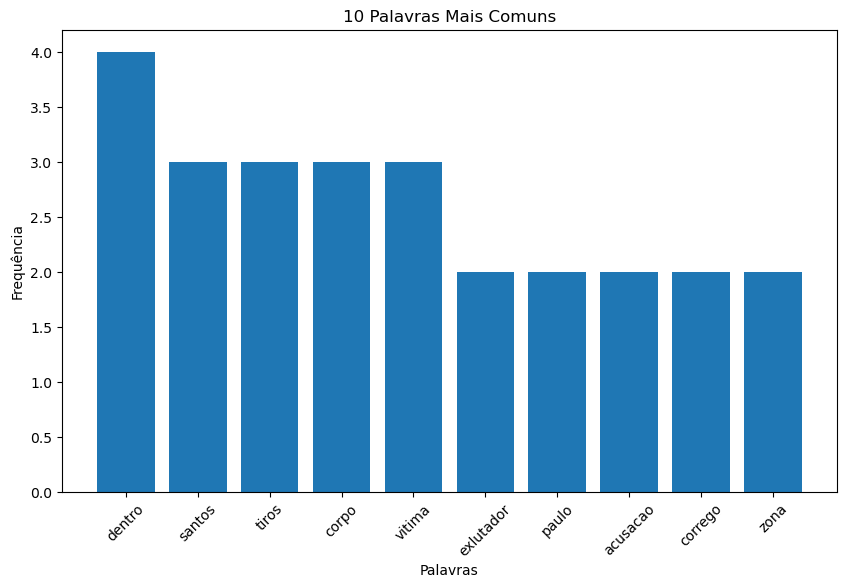

In [49]:
# Obter os 10 tokens mais comuns e suas contagens
tokens_mais_comuns = freq_dist.most_common(10)
palavras, contagens = zip(*tokens_mais_comuns)

# Gráfico de Barras
plt.figure(figsize=(10, 6))
plt.bar(palavras, contagens)
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.title('10 Palavras Mais Comuns')
plt.xticks(rotation=45)
plt.show()

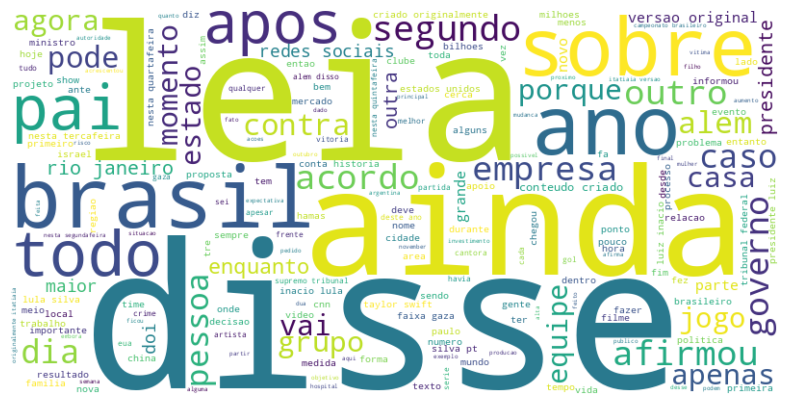

In [50]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join([' '.join(t) for t in token_text])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### spaCy

In [51]:
from spacy.attrs import ORTH # Contagem de frequência de palavras usando Spacy

doc_sp = nlp(" ".join(token2[0]))

count_dict = doc_sp.count_by(ORTH)

In [52]:
sorted_counts = sorted(count_dict.items(), key=lambda item: item[1], reverse=True)

# 10 mais frequentes
top_10_frequent_words = sorted_counts[:10]

# Print
for word, count in top_10_frequent_words:
    print(nlp.vocab.strings[word], count)

santos 3
tiros 3
corpo 3
vitima 3
exlutador 2
paulo 2
acusacao 2
corrego 2
zona 2
tinha 2


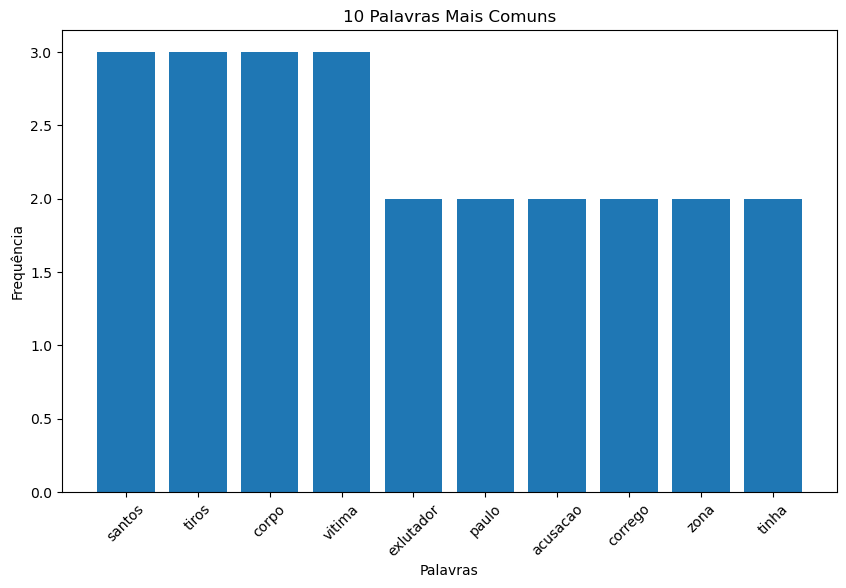

In [53]:
palavras = []
contagens = []
# Obter os 10 tokens mais comuns e suas contagens
for word, count in top_10_frequent_words:
    palavras.append(nlp.vocab.strings[word])
    contagens.append(count)

# Gráfico de Barras
plt.figure(figsize=(10, 6))
plt.bar(palavras, contagens)
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.title('10 Palavras Mais Comuns')
plt.xticks(rotation=45)
plt.show()

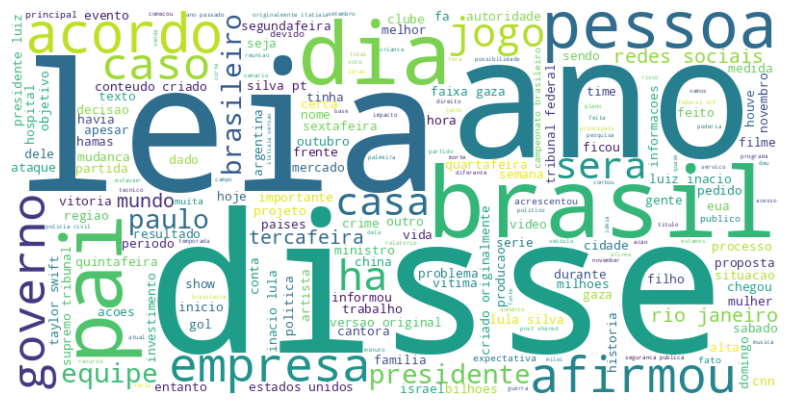

In [54]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join([' '.join(t) for t in token2])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Gensim

In [55]:
from gensim import corpora

dictionary = corpora.Dictionary(token3) 
corpus = [dictionary.doc2bow(text) for text in token3]
print(corpus[1])

[(49, 1), (117, 1), (118, 1), (119, 1), (120, 1), (121, 1), (122, 1), (123, 1), (124, 2), (125, 1), (126, 1), (127, 1), (128, 1), (129, 1), (130, 1), (131, 1), (132, 1), (133, 1), (134, 2), (135, 1), (136, 1), (137, 1), (138, 1), (139, 1), (140, 1), (141, 1), (142, 1), (143, 1), (144, 7), (145, 1), (146, 1), (147, 1), (148, 1), (149, 1), (150, 1), (151, 1), (152, 1), (153, 1), (154, 1), (155, 1), (156, 1), (157, 1), (158, 1), (159, 1), (160, 1), (161, 1), (162, 2), (163, 6), (164, 1), (165, 1), (166, 1), (167, 1), (168, 1), (169, 1), (170, 1), (171, 1), (172, 1), (173, 1), (174, 1), (175, 2), (176, 1), (177, 1), (178, 2), (179, 1), (180, 1), (181, 1), (182, 1), (183, 1), (184, 1), (185, 1), (186, 1), (187, 1)]


In [56]:
mapping = {v: k for k, v in dictionary.token2id.items()}
ttt = [[(mapping[i[0]], i[1]) for i in item] for item in corpus]
print(ttt[0])

[('academia', 1), ('acertaram', 1), ('acordo', 1), ('acusado', 2), ('acusaes', 1), ('acusao', 2), ('admite', 1), ('alm', 1), ('apartamento', 1), ('aps', 1), ('barra', 1), ('beb', 1), ('boletim', 1), ('cadver', 1), ('campinas', 1), ('capital', 1), ('carmo', 1), ('carrinho', 1), ('carro', 1), ('casa', 1), ('casal', 1), ('chegou', 1), ('cmeras', 1), ('colocou', 1), ('compras', 1), ('condomnio', 1), ('contedo', 1), ('corpo', 3), ('criado', 1), ('crime', 2), ('crimes', 2), ('criminal', 1), ('crrego', 2), ('deciso', 1), ('defesa', 2), ('deixando', 1), ('departamento', 1), ('desaparecimento', 1), ('dhpp', 1), ('dias', 1), ('direo', 1), ('disparou', 1), ('dono', 1), ('ellida', 1), ('encontrado', 1), ('espera', 1), ('esposa', 1), ('exlutador', 2), ('famlia', 1), ('ferreira', 1), ('filho', 2), ('frum', 1), ('funda', 1), ('homem', 1), ('homicdio', 1), ('homicdios', 1), ('ido', 1), ('imagens', 1), ('interrogatrio', 1), ('investigao', 1), ('itatiaia', 1), ('jogado', 1), ('jogou', 1), ('jri', 1), ('

In [57]:
sorted_ttt = sorted(ttt[0], key=lambda x: x[1], reverse=True)

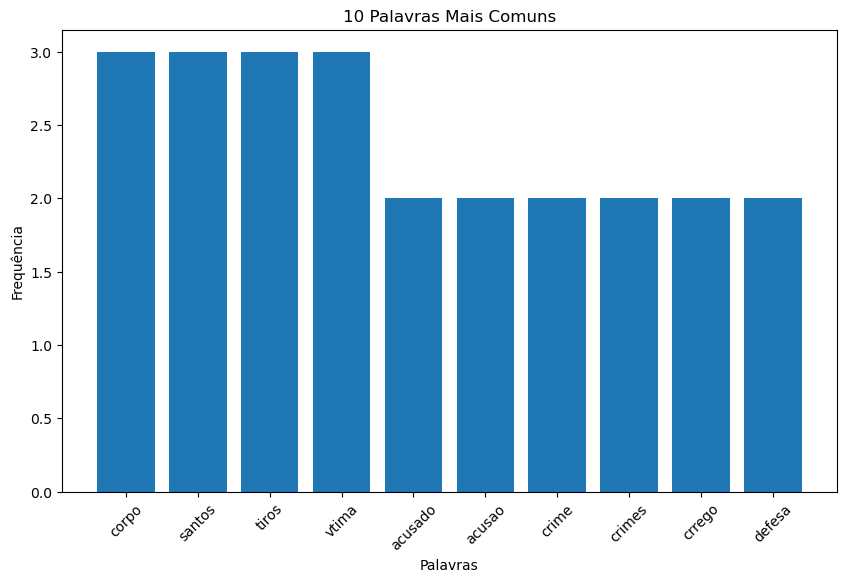

In [58]:
first_ten_elements = sorted_ttt[:10]

palavras = []
contagens = []
# Obter os 10 tokens mais comuns e suas contagens
for word, count in first_ten_elements:
    palavras.append(word)
    contagens.append(count)


# Gráfico de Barras
plt.figure(figsize=(10, 6))
plt.bar(palavras, contagens)
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.title('10 Palavras Mais Comuns')
plt.xticks(rotation=45)
plt.show()

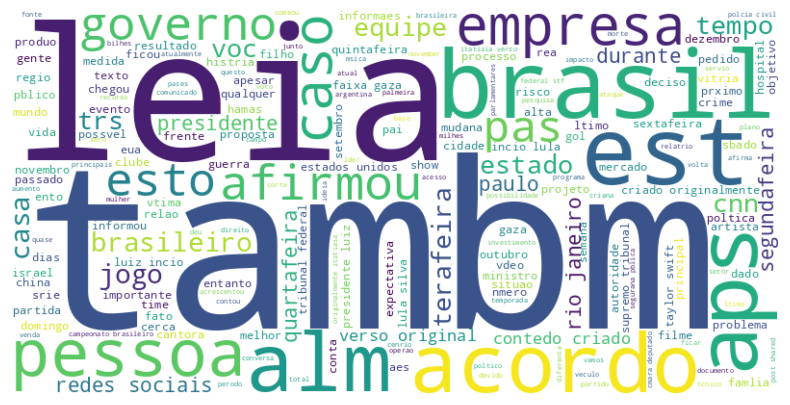

In [59]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join([' '.join(t) for t in token3])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [60]:
from gensim.models import LdaModel

ldamodel = LdaModel(corpus, num_topics=6, id2word=dictionary, passes=50)

for topic in ldamodel.print_topics(num_topics=6, num_words=5): #número de tópicos
    print("Tópicos: ", topic)

Tópicos:  (0, '0.007*"governo" + 0.005*"brasil" + 0.005*"bilhes" + 0.005*"tambm" + 0.004*"leia"')
Tópicos:  (1, '0.013*"presidente" + 0.010*"lula" + 0.008*"federal" + 0.008*"stf" + 0.007*"ministro"')
Tópicos:  (2, '0.007*"paulo" + 0.006*"energia" + 0.006*"tambm" + 0.006*"pessoas" + 0.004*"cnn"')
Tópicos:  (3, '0.012*"israel" + 0.011*"gaza" + 0.009*"hamas" + 0.007*"polcia" + 0.006*"acordo"')
Tópicos:  (4, '0.006*"tambm" + 0.006*"cantora" + 0.006*"show" + 0.006*"taylor" + 0.006*"brasil"')
Tópicos:  (5, '0.008*"brasileiro" + 0.006*"jogo" + 0.006*"leia" + 0.006*"campeonato" + 0.006*"rodada"')
